# Introduction

The purpose of this notebook is to explore the fundamentals of time series analysis using a simulated dataset. We'll focus on understanding key concepts such as trend, seasonality, noise, stationarity, and modeling using ARMA.

In the following cells, we'll walk through the full time series workflow—from visualizing the raw data to building forecasting models—all using Python and tools like `pandas`, `numpy`, `matplotlib`, and `statsmodels.tsa`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

To keep things simple and controlled, we generate our own time series data representing daily ice cream sales over a 3-year period (2022–2024). The data includes a seasonal pattern (using a sine wave to mimic higher sales in warmer months), a gradual upward trend, and random noise to reflect daily fluctuations. By simulating the data ourselves, we can clearly observe the impact of each time series component and build intuition for real-world analysis.

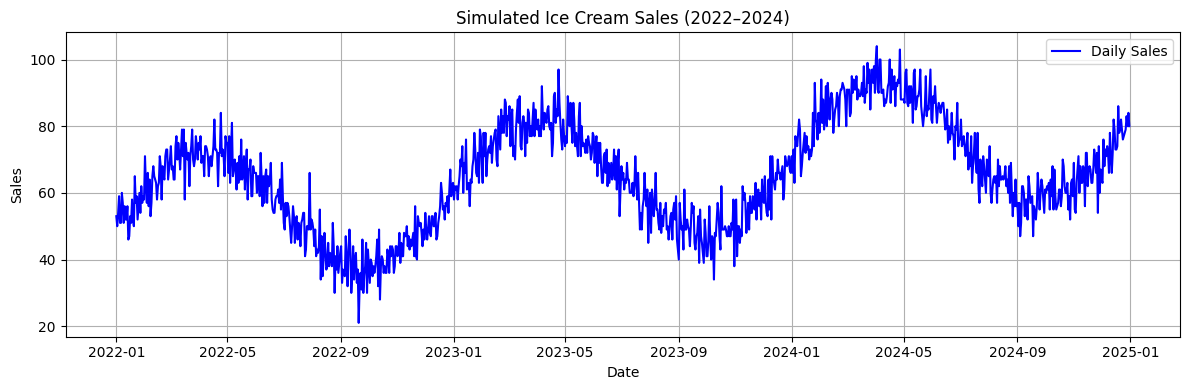

In [2]:
# Set seed for reproducibility
np.random.seed(42)

# Generate date range for 3 years
dates = pd.date_range(start='2022-01-01', end='2024-12-31', freq='D')
n = len(dates)

# Initialize base sales with some random noise
base_sales = 50 + np.random.normal(0, 5, size=n)

# Seasonal component
day_of_year = dates.dayofyear
seasonality = 20 * np.sin((2 * np.pi * day_of_year) / 365)

# Trend component
trend = np.linspace(0, 30, n)

# Combine all components
raw_sales = base_sales + seasonality + trend
sales = np.round(np.clip(raw_sales, a_min=0, a_max=None))

# Create DataFrame
df = pd.DataFrame({'Date': dates, 'Ice_Cream_Sales': sales})
df.set_index('Date', inplace=True)

# Plot with transparent background
plt.figure(figsize=(12, 4), facecolor='none')
plt.plot(df.index, df['Ice_Cream_Sales'], label='Daily Sales', color='blue')
plt.title("Simulated Ice Cream Sales (2022–2024)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.tight_layout()
plt.gca().patch.set_alpha(0)  # Make the axis background transparent
plt.grid(True)
plt.legend()

# To display
plt.show()


In [4]:
df.head()

,Ice_Cream_Sales
Date,
2022-01-01,53.0
2022-01-02,50.0
2022-01-03,54.0
2022-01-04,59.0
2022-01-05,51.0


## Component 1: Trend

The trend represents the long-term direction in a time series. It reflects a general increase or decrease in the data over time, independent of short-term fluctuations or seasonal effects.

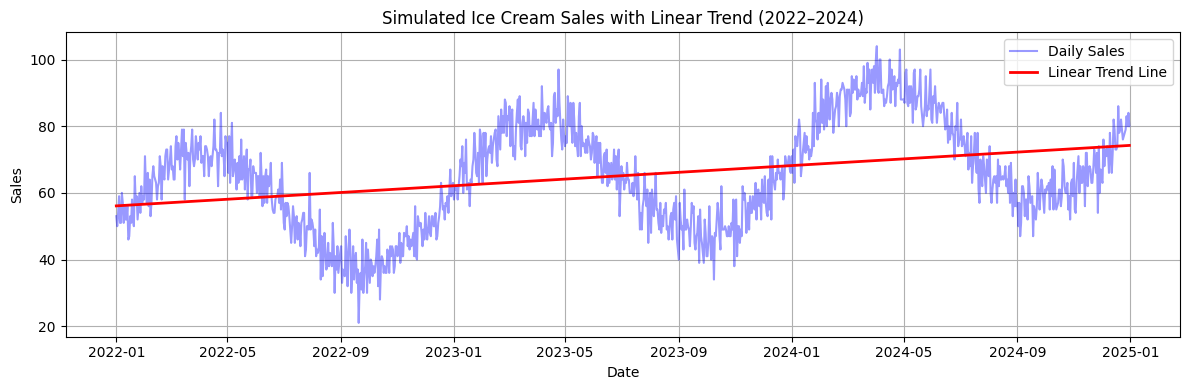

In [3]:
from sklearn.linear_model import LinearRegression
# Linear regression trend line
X = np.arange(n).reshape(-1, 1)
y = df['Ice_Cream_Sales'].values
model = LinearRegression()
model.fit(X, y)
linear_trend = model.predict(X)

# Plot with transparent background
plt.figure(figsize=(12, 4), facecolor='none')
plt.plot(df.index, df['Ice_Cream_Sales'], label='Daily Sales', color='blue', alpha=0.4)
plt.plot(df.index, linear_trend, label='Linear Trend Line', color='red', linewidth=2)
plt.title("Simulated Ice Cream Sales with Linear Trend (2022–2024)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.tight_layout()
plt.gca().patch.set_alpha(0)  # Make the axis background transparent
plt.grid(True)
plt.legend()

# Display
plt.show()

In our simulated ice cream sales data, we introduce a gradual upward trend to represent a steady growth in overall sales over the 3-year period. This could reflect real-world factors like a growing customer base, expanding locations, or increasing popularity.

By adding a linear trend to the data, we’ll be able to observe how it interacts with seasonality and noise, and later, how it affects stationarity and model performance.


## Component 2: Seasonality

Seasonality refers to patterns that repeat at regular intervals over time, often driven by external, cyclical factors like weather, holidays, or time of year.

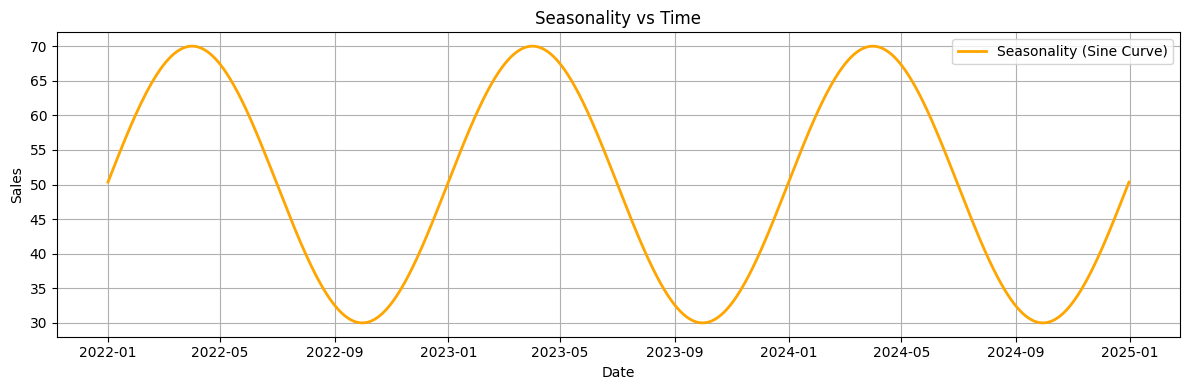

In [4]:
# Calculate smooth seasonal pattern
seasonality_smooth = 20 * np.sin(2 * np.pi * day_of_year / 365)

# Plot with transparent background
plt.figure(figsize=(12, 4), facecolor='none')  # Transparent figure background
plt.plot(df.index, seasonality_smooth + 50, label='Seasonality (Sine Curve)', color='orange', linewidth=2)
plt.title("Seasonality vs Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.gca().patch.set_alpha(0)  # Transparent plot (axis) background
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In our dataset, seasonality models the idea that ice cream sales peak during warmer months and dip during colder ones.

To simulate this, we use a sine function that cycles once per year, creating a smooth, wave-like pattern that rises and falls consistently across each 12-month period. This helps us mimic real-world seasonality and observe its impact on the overall structure of the time series.

When combined with trend and noise, this seasonal component helps create a more realistic and informative dataset for time series analysis.



## Component 3: Noise

Noise refers to the random, unpredictable fluctuations in a time series that can't be explained by trend or seasonality. In real-world data, noise can come from a variety of sources—weather anomalies, special events, store closures, or even human behavior.



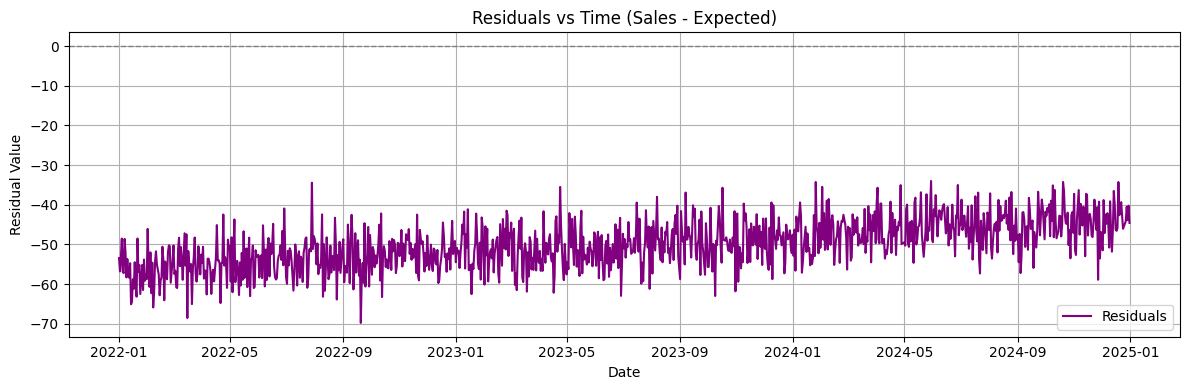

In [5]:
# Expected value = base + trend + seasonality
expected = 50 + linear_trend + seasonality_smooth

# Residuals = actual - expected
residuals = df['Ice_Cream_Sales'].values - expected

# Plot residuals with transparent background
plt.figure(figsize=(12, 4), facecolor='none')
plt.plot(df.index, residuals, label='Residuals', color='purple')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title("Residuals vs Time (Sales - Expected)")
plt.xlabel("Date")
plt.ylabel("Residual Value")
plt.gca().patch.set_alpha(0)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In our simulation, we add noise by including random values drawn from a normal distribution. This adds variability to the sales data from day to day, making the dataset more realistic. While noise can obscure patterns in the data, it’s also a critical part of time series analysis, since it helps us understand the limitations of our models and the uncertainty in our predictions.

By combining trend, seasonality, and noise, we now have a complete time series that we can use to explore key concepts and modeling techniques.

# Stationarity

Before we can apply most time series models, it's important to understand a key concept: stationarity. A time series is considered stationary when its mean, variance, and autocorrelation structure remain constant over time. In other words, the statistical properties of the series do not change as we move through time.

Non-stationary data often contains trends, seasonality, or changing variance, which can violate the assumptions of many forecasting models like ARMA and ARIMA. Therefore, checking for stationarity—and transforming the data if necessary—is a crucial step in the time series workflow.

## PCF Plot: Evidence of Nonstationarity

The Autocorrelation Function (ACF) plot helps us visualize how correlated the time series is with its past values (lags). In a stationary series, autocorrelations drop off quickly as lag increases. However, when there is a trend or seasonality, autocorrelations tend to remain high across many lags.



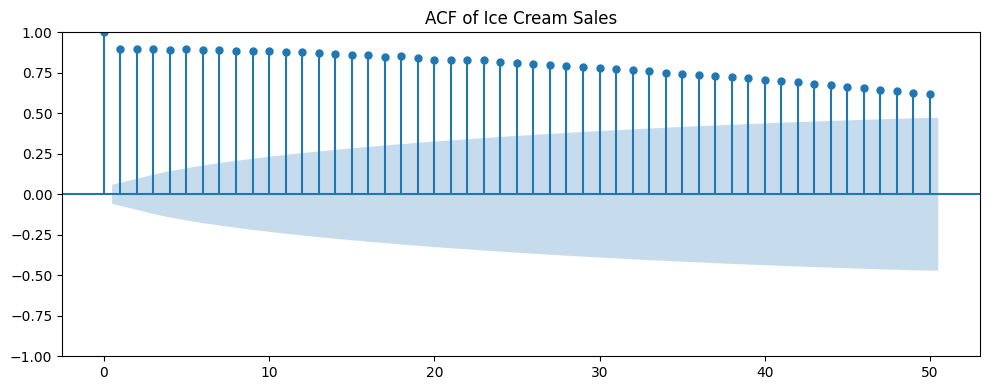

In [6]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize=(10, 4), facecolor='none')  # Transparent figure
plot_acf(df['Ice_Cream_Sales'], lags=50, ax=ax)
ax.set_title("ACF of Ice Cream Sales")
ax.patch.set_alpha(0)  # Transparent plot (axis) background
plt.tight_layout()
plt.show()

In our plot of the raw ice cream sales data, we observe that autocorrelation values stay high throughout many lags, with slow decay. This is a strong sign that our time series is non-stationary, likely due to the seasonal and trending patterns we introduced earlier. We'll confirm this with a formal test next.

## ADF Test

To formally test whether our time series is stationary, we use the **Augmented Dickey-Fuller (ADF) test**. This statistical test checks for the presence of a **unit root**, which indicates nonstationarity.

- Null hypothesis (H₀): The data has a unit root (i.e., it is nonstationary).  
- Alternative hypothesis (H₁): The data is stationary.

We’ll look at the p-value from the test:
- If the p-value is greater than 0.05, we fail to reject the null hypothesis → the data is nonstationary.
- If the p-value is less than 0.05, we reject the null hypothesis → the data is likely stationary.

In [7]:
from statsmodels.tsa.stattools import adfuller

# run  ADF test on the ice cream sales data
result = adfuller(df['Ice_Cream_Sales'])

# print results
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -1.5693464181320385
p-value: 0.49897101463168925


In our case, the ADF test returned a p-value much greater than 0.05, confirming what we saw in the ACF plot: our original ice cream sales data is non-stationary. Next, we’ll apply differencing to remove the trend and seasonality and check again for stationarity.

## Transformation

To make our time series stationary, we apply a technique called differencing. This involves subtracting each data point from its previous value, which helps remove trend and seasonality, making the statistical properties of the series more stable over time.

Mathematically:

$$
y'_t = y_t - y_{t-1}
$$

This transformation often makes the series suitable for modeling with ARMA or ARIMA models.

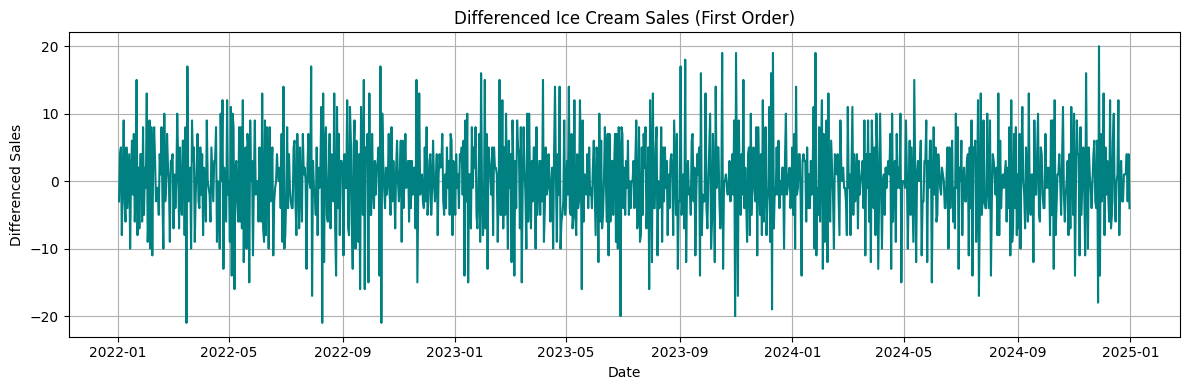

ADF Statistic: -6.360430869180391
p-value: 2.482246498091736e-08


In [8]:
# Apply first-order differencing to the ice cream sales data
df['Differenced'] = df['Ice_Cream_Sales'].diff()

# Drop NaN from the first differenced value
df_diff = df.dropna()

# Run Augmented Dickey-Fuller test on differenced data
adf_result = adfuller(df_diff['Differenced'])
adf_stat = adf_result[0]
p_value = adf_result[1]
critical_values = adf_result[4]

# Re-plot the differenced data with transparent background
plt.figure(figsize=(12, 4), facecolor='none')
plt.plot(df_diff.index, df_diff['Differenced'], color='teal')
plt.title("Differenced Ice Cream Sales (First Order)")
plt.xlabel("Date")
plt.ylabel("Differenced Sales")
plt.gca().patch.set_alpha(0)  # transparent axis background
plt.grid(True)
plt.tight_layout()
plt.show()

# print results
print("ADF Statistic:", adf_stat)
print("p-value:", p_value)

 After differencing, our p-value is less than 0.01, which tells us that our transformed data is now ready for modeling.



# Smoothing

Smoothing is a technique used to reduce noise in a time series and reveal the underlying patterns more clearly. It’s especially helpful for identifying trend and seasonality in noisy data. While smoothing doesn’t make data stationary or directly improve forecasting, it’s a valuable exploratory tool for visualizing the structure of the data before modeling.

There are many different smoothing techniques, but in this notebook, we only apply moving average smoothing to our time series. A moving average (MA) smooths the data by averaging values over a sliding window of a fixed size. This helps filter out random short-term fluctuations and highlights longer-term patterns like trend and seasonality.

Mathematically, a moving average at time
𝑡 with window size
𝑘 is calculated as:

$$
MA_t = \frac{1}{k} \sum_{i=0}^{k-1} y_{t-i}
$$

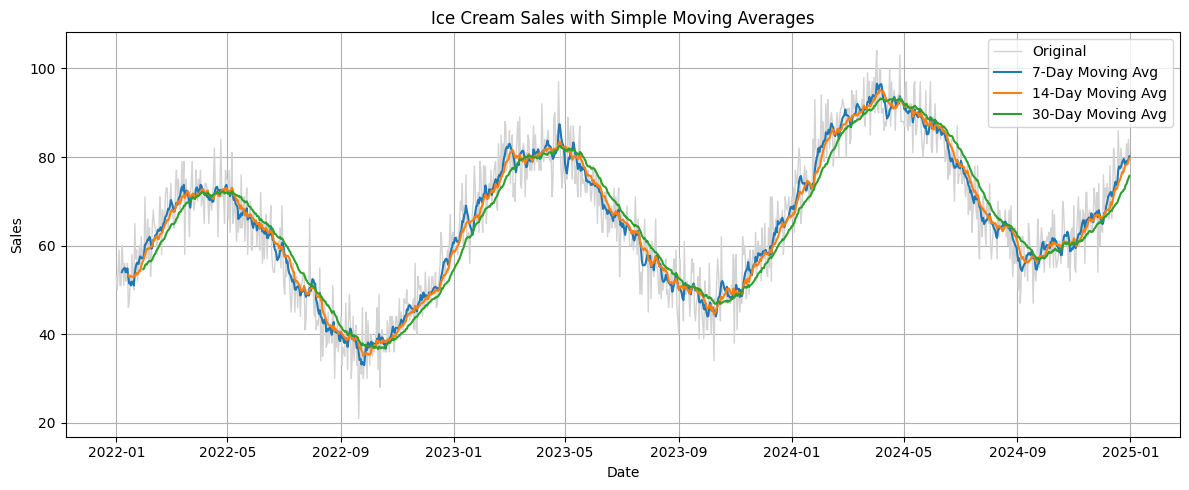

In [9]:
# Apply simple moving averages to smooth the ice cream sales data
# We'll try different window sizes to show different levels of smoothing

window_sizes = [7, 14, 30]  # 1-week, 2-week, and 1-month windows

# Plot the original and smoothed data
plt.figure(figsize=(12, 5), facecolor='none')
plt.plot(df.index, df['Ice_Cream_Sales'], label='Original', color='lightgray', linewidth=1)

for window in window_sizes:
    smoothed = df['Ice_Cream_Sales'].rolling(window=window).mean()
    plt.plot(df.index, smoothed, label=f'{window}-Day Moving Avg')

plt.title("Ice Cream Sales with Simple Moving Averages")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.gca().patch.set_alpha(0)  # transparent axis background
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

We applied different window sizes (e.g., 7-day, 14-day, and 30-day moving averages) to see how the level of smoothing changes.

*   Smaller windows react more quickly to changes but leave more noise.
*   Larger windows smooth the series more heavily but may lag behind real-time shifts.

While moving averages are great for visualization, it's important to note that they assign equal weight to all points in the window and do not adapt to changes in trend or seasonality.

# Modeling

Now that we’ve explored the structure of our time series and prepared the data by making it stationary, we are ready to move into modeling. Time series models help us quantify patterns and forecast future values based on historical behavior.

In this notebook, we’ll focus on autoregressive models (AR), moving average models (MA), and their combination, ARMA models. Before building these models, we need to understand how past values and past forecast errors influence the current value—and that’s where autocorrelation comes in.

## Autocorrelation Function (ACF)

The Autocorrelation Function (ACF) measures how strongly a time series is correlated with its past values at different lags. A lag refers to how many time steps back we look. For example, lag 1 compares today’s value with yesterday’s, lag 2 compares today with two days ago, and so on.

The ACF helps us answer important questions like:
*   How much does today’s value depend on previous values?
*   How many lagged values should we consider when building a model?

In the next step, we’ll plot the ACF and interpret the results to help guide our model selection.

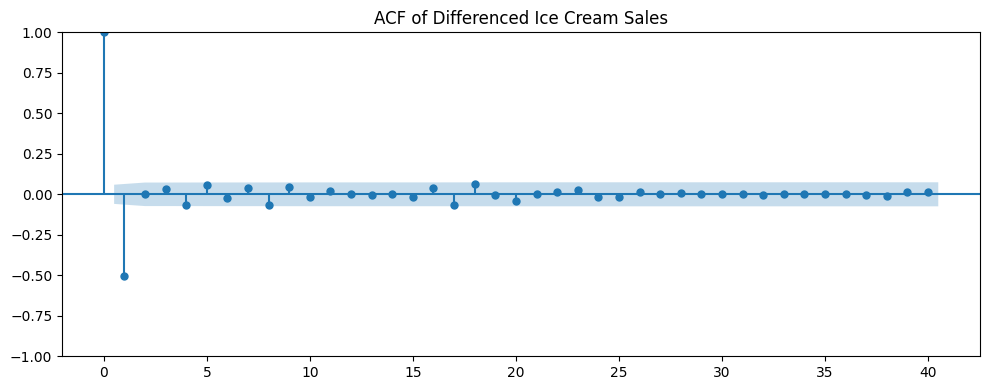

In [10]:
# Plot ACF of the differenced series with transparent background
fig, ax = plt.subplots(figsize=(10, 4), facecolor='none')
plot_acf(df_diff['Differenced'], lags=40, ax=ax)
ax.set_title("ACF of Differenced Ice Cream Sales")
ax.patch.set_alpha(0)  # transparent plot background
plt.tight_layout()
plt.show()

Looking at the ACF plot of our differenced ice cream sales data, we observe a strong spike at lag 1, followed by a quick drop-off, with most subsequent lags falling within the confidence bands. This behavior suggests that the correlation between the current value and its past values fades quickly after the first lag.

This pattern is typical of a series that can be effectively modeled with a moving average (MA) component. Specifically, the sharp cutoff after lag 1 suggests that a first-order moving average model (MA(1)) could be a good fit for capturing the short-term dependencies in the data.

Based on this observation, we will consider q = 1 when setting up our time series model.

## Partial Autocorrelation Function (PACF)

While the ACF helps us understand how current values relate to past forecast errors, the Partial Autocorrelation Function (PACF) helps us understand how current values relate directly to past observations. The PACF measures the correlation between a time series and its lagged values, after removing the influence of shorter lags.

In simpler terms, while the ACF shows total correlation, the PACF shows the direct relationship at each specific lag.

When building autoregressive (AR) models, the PACF is especially useful because it tells us how many past values (lags) are important when predicting the current value.

Next, we will plot the PACF of our stationary ice cream sales data to help decide the appropriate order (p) for the AR part of our model.



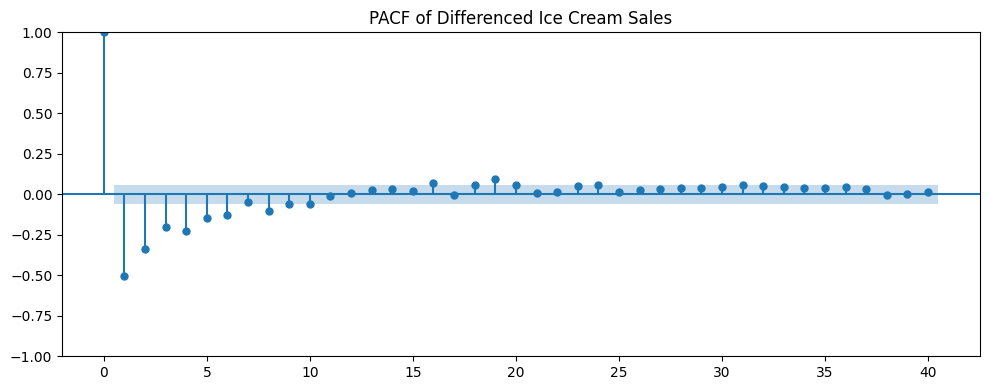

In [11]:
from statsmodels.graphics.tsaplots import plot_pacf

# Plot PACF of the differenced series with transparent background
fig, ax = plt.subplots(figsize=(10, 4), facecolor='none')
plot_pacf(df_diff['Differenced'], lags=40, ax=ax, method='ywm')
ax.set_title("PACF of Differenced Ice Cream Sales")
ax.patch.set_alpha(0)  # transparent plot background
plt.tight_layout()
plt.show()


When examining the PACF plot of our differenced ice cream sales data, we see significant spikes at lag 1 and lag 2, after which the values quickly fall within the confidence bands. This suggests that the current value is directly related to the past two observations, but not beyond that.

This behavior is typical of a time series that can be effectively modeled with an autoregressive (AR) component. Specifically, the sharp drop after lag 2 suggests that an AR model of order 2, or AR(2), would be appropriate.

Based on the PACF, we will consider setting p = 2 when building our model.

## ARMA Model

Based on our ACF and PACF analysis, we decided to build an ARMA(2,1) model for the differenced ice cream sales data. The PACF suggested that the current value is strongly related to the previous two observations (p = 2), while the ACF suggested that the current value is also influenced by the previous forecast error (q = 1).

An ARMA model combines both autoregressive (AR) and moving average (MA) components into a single equation. Mathematically, the ARMA(2,1) model can be written as:

$$
y'_t = \phi_1 y'_{t-1} + \phi_2 y'_{t-2} + \theta_1 \epsilon_{t-1} + \epsilon_t
$$

where:
- y′ₜ is the differenced time series at time t
- ϕ₁ and ϕ₂ are coefficients for the lagged observations
- θ₁ is the coefficient for the lagged error term
- εₜ is white noise

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


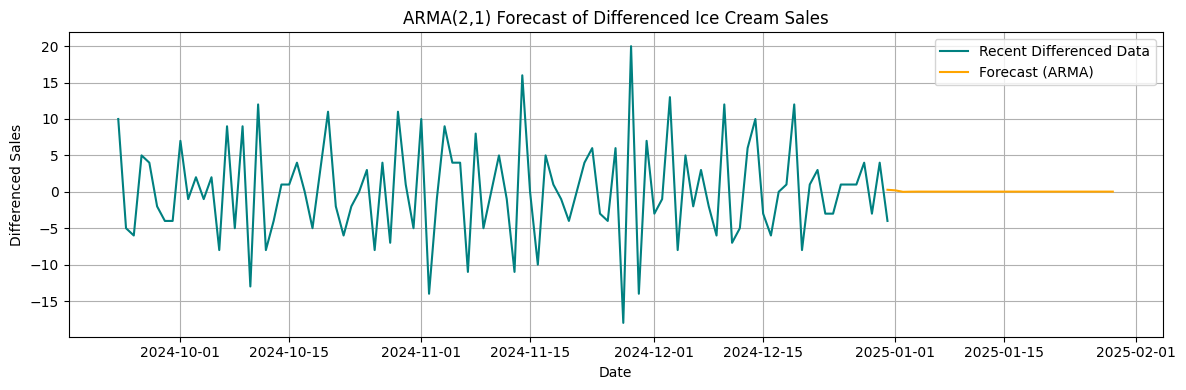

In [12]:
from statsmodels.tsa.arima.model import ARIMA

# Based on the PACF and ACF: ARMA(2,2) as an example (on differenced data)

# Fit ARMA model (ARIMA with d=0)
model = ARIMA(df_diff['Differenced'], order=(2, 0, 1))
arma_result = model.fit()

# Forecast next 30 days
forecast = arma_result.forecast(steps=30)

# Plot forecast
plt.figure(figsize=(12, 4), facecolor='none')
plt.plot(df_diff.index[-100:], df_diff['Differenced'].iloc[-100:], label='Recent Differenced Data', color='teal')
plt.plot(pd.date_range(start=df_diff.index[-1], periods=30, freq='D'), forecast, label='Forecast (ARMA)', color='orange')
plt.title("ARMA(2,1) Forecast of Differenced Ice Cream Sales")
plt.xlabel("Date")
plt.ylabel("Differenced Sales")
plt.gca().patch.set_alpha(0)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


After fitting the ARMA(2,1) model to our differenced ice cream sales data, we generated a 30-day forecast. The model’s predictions quickly flattened around zero, indicating that it does not expect any significant upward or downward change in the differenced values. This outcome suggests that the model believes the future changes in sales will be small and centered around the recent average.

This behavior is common when the differenced series shows a lot of randomness and no strong trend. It means that while the ARMA model captures short-term dependencies, it struggles to project meaningful long-term direction—especially in the presence of underlying seasonal patterns or more complex dynamics that ARMA is not designed to handle.

If the goal is to capture and forecast those seasonal effects, we may need to use a more advanced model like SARIMA, which extends ARMA by including seasonal components.

# Conclusion

In this notebook, we walked through the basics of time series analysis—from simulating data with trend and seasonality to making it stationary, visualizing autocorrelations, and building an ARMA(2,1) model. While our model captured short-term structure, it flattened in its forecast due to randomness and the absence of strong trends in the differenced data.

This workflow is a simplified introduction based on concepts from [Filippo Maria Bianchi’s Python Time Series Handbook](https://filippomb.github.io/python-time-series-handbook/notebooks/00/intro.html), which offers a deeper look into more advanced models like SARIMA, ARIMA, and beyond.

